In [1]:
# ! pip install albumentations==0.4.5

In [2]:
# ! rm -rf ./radlib
# ! git clone https://github.com/vpsingh22/radlib.git


In [3]:
%matplotlib inline
from radlib.model.regularizer import l1_regularization
from radlib.model.train import train 
from radlib.model.test import val
from radlib.model.network import BasicBlock, ResNet, ResNet18
from radlib.data.datasets import TinyImageNet
from radlib.plotter import plot_metric
from radlib.lr_finder import LRFinder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import random
import matplotlib.pyplot as plt

In [4]:
cuda = torch.cuda.is_available()
print('GPU Available?', cuda)
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

GPU Available? True


In [5]:
dataset = TinyImageNet(train_batch_size=128, val_batch_size=128, cuda=cuda, num_workers=16, horizontal_flip_prob=0.3,
                       vertical_flip_prob=0.1, rotate_degree=10, cutout_prob=0.3, cutout_dim=(16, 16),)

Files already downloaded.
Files already downloaded.


In [6]:
train_loader = dataset.loader(train=True)
val_loader = dataset.loader(train=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200


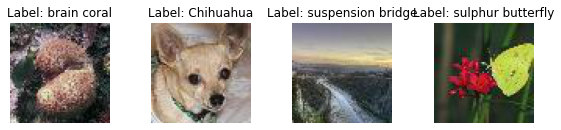

In [7]:
classes = dataset.classes
print(len(classes))
# Set number of images to display
num_images = 4

# Display images with labels
fig, axs = plt.subplots(1, 4, figsize=(8, 8))
fig.tight_layout()
sample = None
for i in range(num_images):
    if i == 0:
        sample = dataset.unnormalize(dataset.val_data[i][0], transpose=True)
    idx = random.randint(0, len(dataset.val_data))
    axs[i].axis('off')
    axs[i].set_title(f'Label: {classes[dataset.val_data[idx][1]].split(",")[0]}')
    axs[i].imshow(dataset.unnormalize(dataset.val_data[idx][0], transpose=True))

In [8]:
from torchsummary import summary
model = ResNet18(num_classes=len(classes)).to(device)  # Create model
# size = image_size(sample)
print(sample.shape)
print(summary(model, input_size=(3, 64, 64)))

torch.Size([64, 64, 3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm

In [9]:
min_lr = 1e-6
end_lr = 0.1
num_iter = 400
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=momentum)

In [10]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=end_lr, num_iter=400, step_mode='exp')


Learning rate search finished. See the graph with {finder_name}.plot()


Loss: 5.031965861124012
Initial LR suggestion: Minimum Loss
Best Initial LR: 1.45E-02


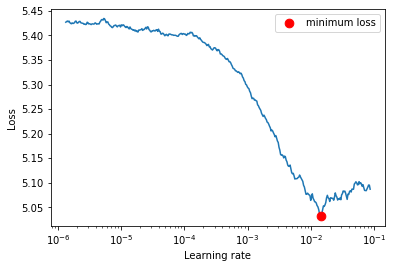

In [11]:

# Print loss
print('Loss:', lr_finder.best_loss)

# return best initial lr
# Plot learning rate vs loss
_, best_initial_lr = lr_finder.plot()
# print(best_initial_lr)
# Reset graph
lr_finder.reset()

In [12]:
momentum = 0.9
total_epochs = 50
patience = 2

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_initial_lr, momentum=momentum)
scheduler = ReduceLROnPlateau(optimizer, patience = 2)

In [14]:

train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
for epoch in range(1, total_epochs + 1):
    print(f'Epoch {epoch}:')
    train_loss, train_accuracy = train(model, train_loader, device, optimizer, criterion)
    val_loss, val_accuracy = val(model, val_loader, device, criterion)
    train_losses.append(train_loss), train_accuracies.append(train_accuracy)
    val_losses.append(val_loss), val_accuracies.append(val_accuracy)

  0%|          | 0/602 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0336, Accuracy: 3574/33000 (10.83%)

Epoch 2:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0271, Accuracy: 6874/33000 (20.83%)

Epoch 3:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0256, Accuracy: 8169/33000 (24.75%)

Epoch 4:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0254, Accuracy: 8807/33000 (26.69%)

Epoch 5:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0221, Accuracy: 10880/33000 (32.97%)

Epoch 6:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0212, Accuracy: 11869/33000 (35.97%)

Epoch 7:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0211, Accuracy: 12171/33000 (36.88%)

Epoch 8:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0209, Accuracy: 12370/33000 (37.48%)

Epoch 9:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0203, Accuracy: 12877/33000 (39.02%)

Epoch 10:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0190, Accuracy: 13966/33000 (42.32%)

Epoch 11:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0180, Accuracy: 14740/33000 (44.67%)

Epoch 12:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0182, Accuracy: 14688/33000 (44.51%)

Epoch 13:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0176, Accuracy: 15424/33000 (46.74%)

Epoch 14:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0186, Accuracy: 14859/33000 (45.03%)

Epoch 15:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0179, Accuracy: 15375/33000 (46.59%)

Epoch 16:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0175, Accuracy: 15901/33000 (48.18%)

Epoch 17:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0180, Accuracy: 15514/33000 (47.01%)

Epoch 18:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0170, Accuracy: 16129/33000 (48.88%)

Epoch 19:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0169, Accuracy: 16290/33000 (49.36%)

Epoch 20:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0165, Accuracy: 16752/33000 (50.76%)

Epoch 21:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0174, Accuracy: 16383/33000 (49.65%)

Epoch 22:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0190, Accuracy: 15585/33000 (47.23%)

Epoch 23:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0176, Accuracy: 16611/33000 (50.34%)

Epoch 24:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0186, Accuracy: 16186/33000 (49.05%)

Epoch 25:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0183, Accuracy: 16232/33000 (49.19%)

Epoch 26:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0183, Accuracy: 16511/33000 (50.03%)

Epoch 27:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0182, Accuracy: 16725/33000 (50.68%)

Epoch 28:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0183, Accuracy: 16734/33000 (50.71%)

Epoch 29:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0181, Accuracy: 16959/33000 (51.39%)

Epoch 30:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0177, Accuracy: 17324/33000 (52.50%)

Epoch 31:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0191, Accuracy: 16658/33000 (50.48%)

Epoch 32:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0184, Accuracy: 16833/33000 (51.01%)

Epoch 33:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0189, Accuracy: 16988/33000 (51.48%)

Epoch 34:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0185, Accuracy: 17059/33000 (51.69%)

Epoch 35:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0191, Accuracy: 17143/33000 (51.95%)

Epoch 36:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0189, Accuracy: 17195/33000 (52.11%)

Epoch 37:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0197, Accuracy: 16985/33000 (51.47%)

Epoch 38:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0195, Accuracy: 17107/33000 (51.84%)

Epoch 39:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0196, Accuracy: 17158/33000 (51.99%)

Epoch 40:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0194, Accuracy: 17293/33000 (52.40%)

Epoch 41:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0194, Accuracy: 17300/33000 (52.42%)

Epoch 42:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0200, Accuracy: 17125/33000 (51.89%)

Epoch 43:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0202, Accuracy: 17101/33000 (51.82%)

Epoch 44:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0197, Accuracy: 17489/33000 (53.00%)

Epoch 45:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0199, Accuracy: 17399/33000 (52.72%)

Epoch 46:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0203, Accuracy: 17391/33000 (52.70%)

Epoch 47:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0202, Accuracy: 17522/33000 (53.10%)

Epoch 48:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0199, Accuracy: 17611/33000 (53.37%)

Epoch 49:


  0%|          | 0/602 [00:00<?, ?it/s]


Validation set: Average loss: 0.0203, Accuracy: 17403/33000 (52.74%)

Epoch 50:


Loss=0.20 Batch_ID=601 Accuracy=93.45: 100%|██████████| 602/602 [02:27<00:00,  4.09it/s]



Validation set: Average loss: 0.0202, Accuracy: 17491/33000 (53.00%)



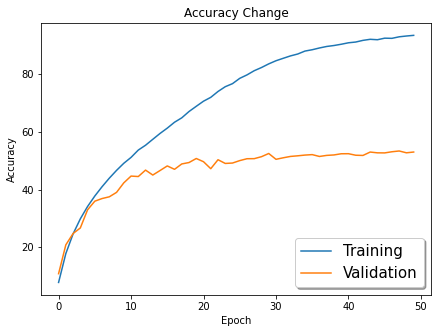

In [16]:
plot_metric(
    {'Training': train_accuracies, 'Validation': val_accuracies}, 'Accuracy'
)